## T cell reference: synovium, gut, kidney, and balf using weighted PCA, harmony, and SNN
## GZMK+ CD8 T cells outnumber GZMB+ CD8 T cells in many different tissues and disease states
## Fan Zhang

In [1]:
suppressMessages({
                    library(data.table)
                    library(reticulate)
                    library(Rcpp)
                    library(scales)
                    library(irlba)
                    library(singlecellmethods)
                    library(pbapply)
                    library(patchwork)
                    library(pheatmap)
                    library(entropy)
                    library(Rtsne)
                    library(loe)
                    library(RSpectra)
                    library(igraph)
                    library(viridis)
                    library(RColorBrewer)
                    library(matrixStats)
                    library(parallel)   
                    library(harmony)
                    library(magrittr)
                    library(gridExtra)
                    library(ggthemes)
                    library(cowplot)
                    library(reticulate)
                    library(ggbeeswarm)
                    library(ggrepel)
                    library(plyr)
                    library(ggplot2)
                    library(dplyr)
                    library(MASS) 
                    library(grid)
                    require(gdata)
                 })

In [2]:
meta_colors <- list(

  disease = c(
    "healthy" = "#B3B3B3",
    "mild"   = "#B2DF8A",
    "severe" = "#33A02C",
   
    "Healthy BALF" = "#B3B3B3",
    "Mild COVID-19"   = "#B2DF8A", 
    "Severe COVID-19" = "#33A02C",
      
    "Healthy BALF" = "#B3B3B3",
    "Mild BALF"   = "#B2DF8A", 
    "Severe BALF" = "#33A02C",
      
    "Inflamed UC" = "#A6761D", 
    "Non-inflamed UC" = "#E6AB02", 
    "Healthy colon" = "#E5D8BD", 
    "Crohn" = "#FF7F00", 
    "Inflamed Crohn" = "#FF7F00", 
    "Non-inflamed Crohn" = "#D9D9D9",  
      
    "Healthy kidney" = "#1F8888",
    "SLE kidney" = "#1F78B4",   
    "RA synovium" =  "#E31A1C", 
    "OA synovium"  =  "#FB9A99", 
      
    "Inflamed IBD" = "#A6761D", 
    "Non-inflamed IBD" = "#E6AB02", 
    "healthy (IBD)" = "#E5D8BD", 
    "Ctrl" = "#C7EAE5", 
      
    "Hypersensitivity pneumonitis" = "#35978F",
    "HP lung" = "#35978F",  

    "SLE" = "#1F78B4",   
    "RA" =  "#E31A1C",
    "OA"  =  "black"
  ),

  "dataset" = c(    
    "AMP SLE Phase 1 Celseq" = "#006837",
    "RA" = "#6A3D9A",
    "AMP RA" = "#6A3D9A", 
    "AMP RA Phase 1" = "#E31A1C",
    "Rahul" = "#FC8D62",
    "Crohn (Venema)" = "#FF7F00", 
    "UC (Smillie)" = "#A6761D",
    "Lung disease (Reyfman)" = "#7570B3",
    "AMP SLE" = "#1F78B4", 
    "RA" = "#E31A1C"
  ),
    
  "tissue" = c(
    "BALF"   = "#66A61E",
    "Colon"  = "#A6761D", 
    "Ileum"  = "#E6AB02",
    "Kidney" =  "#1F78B4",
    "Lung"  =  "grey",
    "Synovium" = "#E31A1C"
      )
    
)

    

set1 = c( "#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "#FFFF33", "#A65628", "#F781BF", "#999999")
set3 = c("#8DD3C7", "#FFFFB3", "#BEBADA", "#FB8072", "#80B1D3", "#FDB462", "#B3DE69", "#FCCDE5", "#D9D9D9", "#BC80BD", "#CCEBC5", "#FFED6F")
set2 = c("#66C2A5", "#FC8D62", "#8DA0CB", "#E78AC3", "#A6D854", "#FFD92F", "#E5C494", "#B3B3B3")
colors37 = c("#466791","#60bf37","#953ada","#4fbe6c","#ce49d3","#a7b43d","#5a51dc","#d49f36","#552095","#507f2d","#db37aa","#84b67c","#a06fda","#df462a","#5b83db","#c76c2d","#4f49a3","#82702d","#dd6bbb","#334c22","#d83979","#55baad","#dc4555","#62aad3","#8c3025","#417d61","#862977","#bba672","#403367","#da8a6d","#a79cd4","#71482c","#c689d0","#6b2940","#d593a7","#895c8b","#bd5975")

In [4]:
# Functions
FindVariableGenesBatch <- function(exprs_mat, meta_df, genes_exclude = NULL, ngenes_use = 1e3, expr_min = .1) {
    if (!is.null(genes_exclude)) {
        genes_use <- setdiff(row.names(exprs_mat), genes_exclude)
    }
    x_res <- split(meta_df$cell, meta_df$sample) %>% lapply(function(x) {
        FindVariableGenesSeurat(exprs_mat[genes_use, x]) %>% 
            subset(gene.mean >= expr_min) %>% 
            tibble::rownames_to_column("gene") %>% 
            dplyr::arrange(-gene.dispersion) %>%
            head(ngenes_use)
    })
    data.table(Reduce(rbind, x_res))[, .N, by = gene][order(-N)]    
}



FindVariableGenesSeurat <- function (data, x.low.cutoff = 0.1, x.high.cutoff = 8,
                                     y.cutoff = 1, y.high.cutoff = Inf, num.bin = 0,
                                     binning.method = "equal_width", sort.results = TRUE,
                                     display.progress = TRUE, ...)
{
    genes.use <- rownames(data)
    if (class(data) != "dgCMatrix") {
        data <- as(as.matrix(data), "dgCMatrix")
    }
    ## (1) get means and variances
    gene.mean <- FastExpMean(data, display.progress)
    names(gene.mean) <- genes.use
    gene.dispersion <- FastLogVMR(data, display.progress)
    names(gene.dispersion) <- genes.use

    gene.dispersion[is.na(x = gene.dispersion)] <- 0
    gene.mean[is.na(x = gene.mean)] <- 0

    mv.df <- data.frame(gene.mean, gene.dispersion)
    rownames(mv.df) <- rownames(data)

    ## (OPTIONAL) do the binning correction
    if (num.bin > 0) {
      if (binning.method == "equal_width") {
          data_x_bin <- cut(x = gene.mean, breaks = num.bin)
      }
      else if (binning.method == "equal_frequency") {
          data_x_bin <- cut(x = gene.mean, breaks = c(-1, quantile(gene.mean[gene.mean >
              0], probs = seq(0, 1, length.out = num.bin))))
     }
      else {
          stop(paste0("Invalid selection: '", binning.method,
              "' for 'binning.method'."))
      }
      names(x = data_x_bin) <- names(x = gene.mean)
      mean_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = mean)
      sd_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = sd)
      gene.dispersion.scaled <- (gene.dispersion - mean_y[as.numeric(x = data_x_bin)])/sd_y[as.numeric(x = data_x_bin)]
      gene.dispersion.scaled[is.na(x = gene.dispersion.scaled)] <- 0
      ##names(gene.dispersion.scaled) <- names(gene.mean)

      mv.df$gene.dispersion.scaled <- gene.dispersion.scaled
    }

    return(mv.df)
}

environment(FindVariableGenesSeurat) <- asNamespace("Seurat")

ScaleDataSeurat <- function (data.use, margin = 1, scale.max = 10,
                                block.size = 1000) {

    if (margin == 2) data.use %<>% t
    max.block <- ceiling(nrow(data.use)/block.size)

    ## Define data and functions to use in sparse and dense cases
    if (class(data.use) == "dgCMatrix" | class(data.use) == "dgTMatrix") {
        scale_fxn <- function(x) {
            FastSparseRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
        }
    } else {
        scale_fxn <- function(x) {
            FastRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
       }
        data.use <- as.matrix(data.use)
    }

    ## Do scaling, at once or in chunks
    if (max.block == 1) {
        scaled.data <- scale_fxn(data.use)
    } else {
        scaled.data <- matrix(NA, nrow(data.use), ncol(data.use))
        for (i in 1:max.block) {
            idx.min <- (block.size * (i - 1))
            idx.max <- min(nrow(data.use), (block.size * i - 1) + 1)
            my.inds <- idx.min:idx.max
            scaled.data[my.inds, ] <- scale_fxn(data.use[my.inds, , drop = F])
        }
    }

    colnames(scaled.data) <- colnames(data.use)
    row.names(scaled.data) <- row.names(data.use)
    scaled.data[is.na(scaled.data)] <- 0
    if (margin == 2) scaled.data %<>% t
    return(scaled.data)
}
environment(ScaleDataSeurat) <- asNamespace("Seurat")


fig.size <- function(height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

SingleFeaturePlotSeurat <- function (data.use, feature, data.plot, pt.size, pch.use, cols.use,
    dim.codes, min.cutoff, max.cutoff, coord.fixed, no.axes,
    no.title = FALSE, no.legend, dark.theme, vector.friendly = FALSE,
    png.file = NULL, png.arguments = c(10, 10, 100))
{
    if (vector.friendly) {
        previous_call <- blank_call <- png_call <- match.call()
        blank_call$pt.size <- -1
        blank_call$vector.friendly <- FALSE
        png_call$no.axes <- TRUE
        png_call$no.legend <- TRUE
        png_call$vector.friendly <- FALSE
        png_call$no.title <- TRUE
        blank_plot <- eval(blank_call, sys.frame(sys.parent()))
        png_plot <- eval(png_call, sys.frame(sys.parent()))
        png.file <- SetIfNull(x = png.file, default = paste0(tempfile(),
            ".png"))
        ggsave(filename = png.file, plot = png_plot, width = png.arguments[1],
            height = png.arguments[2], dpi = png.arguments[3])
        to_return <- AugmentPlot(blank_plot, png.file)
        file.remove(png.file)
        return(to_return)
    }
    idx.keep <- which(!is.na(data.use[feature, ]))
    data.gene <- data.frame(data.use[feature, idx.keep])
#     data.gene <- na.omit(object = data.frame(data.use[feature,
#         ]))
    min.cutoff <- SetQuantile(cutoff = min.cutoff, data = data.gene)
    max.cutoff <- SetQuantile(cutoff = max.cutoff, data = data.gene)
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    data_plot <- data.plot[idx.keep, ]
    data_plot$gene <- data.gene
    if (length(x = cols.use) == 1) {
        brewer.gran <- brewer.pal.info[cols.use, ]$maxcolors
    }
    else {
        brewer.gran <- length(x = cols.use)
    }
    if (all(data.gene == 0)) {
        data.cut <- 0
    }
    else {
        data.cut <- as.numeric(x = as.factor(x = cut(x = as.numeric(x = data.gene),
            breaks = brewer.gran)))
    }
    data_plot$col <- as.factor(x = data.cut)
    p <- data_plot %>%
        dplyr::arrange(col) %>%
        ggplot(mapping = aes(x = x, y = y))
    if (brewer.gran != 2) {
        if (length(x = cols.use) == 1) {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_brewer(palette = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
        else {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_manual(values = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
    }
    else {
        if (all(data_plot$gene == data_plot$gene[1])) {
            warning(paste0("All cells have the same value of ",
                feature, "."))
            p <- p + geom_point(color = cols.use[1], size = pt.size,
                shape = pch.use)
        }
        else {
            p <- p + geom_point(mapping = aes(color = gene),
                size = pt.size, shape = pch.use) + scale_color_viridis(option = "plasma", end = .9
    )
        }
    }
    if (dark.theme) {
        p <- p + DarkTheme()
    }
    if (no.axes) {
        p <- p + theme(axis.line = element_blank(), axis.text.x = element_blank(),
            axis.text.y = element_blank(), axis.ticks = element_blank(),
            axis.title.x = element_blank(), axis.title.y = element_blank())
        if (!no.title)
            p <- p + labs(title = feature, x = "", y = "")
        if (no.title)
            p <- p + labs(x = "", y = "")
    }
    else {
        if (no.title)
            p <- p + labs(x = dim.codes[1], y = dim.codes[2])
        if (!(no.title))
            p <- p + labs(title = feature) + labs(x = "", y = "")
    }
    if (no.legend) {
        p <- p + theme(legend.position = "none")
    }
    if (coord.fixed) {
        p <- p + coord_fixed()
    }
    return(p)
}
environment(SingleFeaturePlotSeurat) <- asNamespace("Seurat")

PlotFeatures <- function(umap_use, features_plot, exprs_use, cells_use, ncols, pt_size = .5, pt_shape = ".", q_lo = "q10", q_hi = "q90") {
    if (missing(cells_use)) cells_use <- 1:nrow(umap_use)
    if (missing(ncols)) ncols <- round(sqrt(length(features_plot)))
    
    plt_list <- lapply(features_plot, function(feature_use) {
        SingleFeaturePlotSeurat(exprs_use[, cells_use], feature_use, data.frame(x = umap_use[cells_use, 1], y = umap_use[cells_use, 2]),
                                pt.size = pt_size, pch.use = pt_shape, cols.use = c("lightgrey", "blue"),
                                dim.codes = c("UMAP 1", "UMAP 2"), min.cutoff = c(q10 = q_lo), max.cutoff = c(q90 = q_hi),
                                coord.fixed = FALSE, no.axes = FALSE, dark.theme = FALSE, no.legend = TRUE)
    })
    plot_grid(plotlist = plt_list, ncol = ncols)
    #return(plt_list)
}

BuildSNNSeurat <- function (data.use, k.param = 30, prune.SNN = 1/15, nn.eps = 0) {
    my.knn <- nn2(data = data.use, k = k.param, searchtype = "standard", eps = nn.eps)
    nn.ranked <- my.knn$nn.idx

    snn_res <- ComputeSNN(nn_ranked = nn.ranked, prune = prune.SNN)
    rownames(snn_res) <- row.names(data.use)
    colnames(snn_res) <- row.names(data.use)
    return(snn_res)
}
environment(BuildSNNSeurat) <- asNamespace("Seurat")

NormalizeDataSeurat <- function(A, scaling_factor = 1e4, do_ftt = FALSE) {
	A@x <- A@x / rep.int(Matrix::colSums(A), diff(A@p))
    A@x <- scaling_factor * A@x
    if (do_ftt) {
        A@x <- sqrt(A@x) + sqrt(1 + A@x)
    } else {
        A@x <- log(1 + A@x)
    }
	return(A)
}

In [5]:
# weighted PCA is in immunogenomics/singlecellmethods, function weighted_pca
library(singlecellmethods)
weighted_pca <- function(X, weights, genes_use=NULL, npc=20, do_corr=TRUE, scale_thresh=10) {
    if (!identical(length(weights), ncol(X))) {
        stop('Columns in X must match length of weights')
    }
    
#     y <- factor(y)
#     weights <- as.numeric((1 / prop.table(table(y)))[y]) / nlevels(y)
    if (any(is.na(weights))) {
        idx_keep <- which(is.na(weights))
#         y <- y[idx_keep]
        weights <- weights[idx_keep]
        X <- X[, idx_keep]
    }
    if (is.null(genes_use)) {
        genes_use <- row.names(X)
    } else if (length(genes_use) < nrow(X)) {
        if (any(!genes_use %in% row.names(X))) {
            stop('genes_use not in rownames of X')
        }
        X <- X[genes_use, ]
    }
    
    ## weighted z-scores
#     mu <- X %>% apply(1, function(x) {SDMTools:::wt.mean(x, weights)})
#     sig <- X %>% apply(1, function(x) {SDMTools:::wt.sd(x, weights)})
    mu <- rowMeans(X, weights = weights)
    sig <- rowSDs(X, weights = weights)
    
    # Added 12/9/19: save weighted scaling means and std devs
    vargenes_means_sds <- tibble(
        symbol = genes_use,
        mean = mu
    )
    vargenes_means_sds$stddev <- sig
    # finish added 12/9/19
    
    X <- scaleDataWithStats(X, mu, sig) 
    X <- X[which(is.na(rowSums(X)) == 0), ]
    if (do_corr) {
        X <- X %>% scale() %>% pmin(scale_thresh) %>% pmax(-scale_thresh)
    }
    
    ## weighted SVD
#     pres <- rsvd::rsvd(X %*% Matrix::Diagonal(x = sqrt(weights)), k = npc)
    pres <- RSpectra::svds(X %*% Matrix::Diagonal(x = sqrt(weights)), npc)
    V <- (Matrix::Diagonal(x = 1 / sqrt(weights)) %*% pres$v) %*% diag(pres$d)
    V <- as.matrix(V)
    colnames(V) <- paste0('PC', 1:npc)
    row.names(V) <- colnames(X)
    colnames(pres$u) <- paste0('PC', 1:npc)
    row.names(pres$u) <- row.names(X)
    return(list(loadings = pres$u, embeddings = V, vargenes = vargenes_means_sds))
}

# Cosine normalize values
cosine_normalize <- function(X, MARGIN = 1, do_safe = TRUE) {
    if (do_safe) {
        X <- sweep(X, MARGIN, apply(X, MARGIN, max), "/")
    }
    sweep(X, MARGIN, apply(X, MARGIN, function(x) sqrt(sum(x^2))), "/")
}
                           
                           
                           
do_pca <- function(X, weights, genes_use=NULL, npc=10, do_corr=TRUE) {
    if (is.null(genes_use)) {
        genes_use <- row.names(X)
    }
    mu <- X[genes_use, ] %>% apply(1, function(x) {SDMTools:::wt.mean(x, weights)})
    sig <- X[genes_use, ] %>% apply(1, function(x) {SDMTools:::wt.sd(x, weights)})
    
    X <- X[genes_use, ] %>% scaleDataWithStats(mu, sig) 
    X <- X[which(is.na(rowSums(X)) == 0), ]
    if (do_corr) {
        X <- scale(X)
    }
    pres <- rsvd::rsvd(X, k = npc)
    V <- pres$v %*% diag(pres$d)
    V <- data.table(V)
    colnames(V) <- paste0('PC', 1:npc)
    return(V)    
}
                           
get_stats <- function(X, weights, genes_use=NULL) {
    if (is.null(genes_use)) {
        genes_use <- row.names(X)
    }
    mu <- X[genes_use, ] %>% apply(1, function(x) {SDMTools:::wt.mean(x, weights)})
    sig <- X[genes_use, ] %>% apply(1, function(x) {SDMTools:::wt.sd(x, weights)})
    return(list(mu = mu, sig = sig))
}

## Load already aggregated cross diseased tissue single-cell reference from Zhang, et al, Genome Medicine, 2021

In [3]:
meta_all <- readRDS("../2020_05_14_COVID19_RA_SLE_UC_Crohn_MS_lung/meta_all_COVID19_RA_Rahul_SLE_UC_Crohn_MS_lung_pca_harmony_umap_cluster_new_new_new_2020-05-26.rds")
exprs_norm <- readRDS("../2020_05_14_COVID19_RA_SLE_UC_Crohn_MS_lung/exprs_norm_COVID19_RA_Rahul_SLE_UC_Crohn_MS_lung_pca_harmony_umap_cluster_new_new_2020-05-26.rds")

## Only integrate CD8 T cells

In [162]:
t_barcode <- meta_all[which(meta_all$broad_cell_type == "CD8 T"),]$cell
meta_all_cd8 <- meta_all[which(meta_all$cell %in% t_barcode), ]
exprs_norm_cd8 <- exprs_norm[, t_barcode]
all(meta_all_cd8$cell == colnames(exprs_norm_cd8))
dim(meta_all_cd8)

[1] TRUE

[1] 29363    38

In [164]:
meta_all_cd8 <- meta_all_cd8[, 1:12]
colnames(meta_all_cd8)

[1] "cell"         "dataset"      "technology"   "sample"       "disease"     
 [6] "cell_type"    "nUMI"         "nGene"        "percent_mito" "percent.ribo"
[11] "tissue"       "disease_new"

In [165]:
# Find varible genes
genes_exclude <- grep("^MT-|^RPL|^RPS|MALAT1|MIR-", row.names(exprs_norm_cd8), value = TRUE)
meta_all_cd8$sample <- as.character(meta_all_cd8$sample)
meta_all_cd8$cell <- as.character(meta_all_cd8$cell)

vargenes_df <- FindVariableGenesBatch(exprs_norm_cd8, meta_all_cd8, genes_exclude, 0.3e3)
nrow(vargenes_df)
table(vargenes_df$N)
var_genes <- vargenes_df$gene
head(var_genes)

[1] 8539


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
2926 2001 1266  736  438  279  164  117   93   48   37   40   30   27   15   17 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
  21   14   12    9   10   11    9    8   13    2    7    6    5    9    4    5 
  33   34   35   36   37   38   39   40   41   42   43   44   45   46   48   50 
   3    7    3    5    5    4    2    4    3    5    2    4    4    1    1    3 
  51   53   54   55   56   57   58   59   60   61   62   63   64   65   66   67 
   6    4    2    5    1    1    3    2    1    3    1    1    2    3    3    4 
  68   69   70   71   72   73   74   75   77   78   79   80   81   82   83   84 
   1    2    4    2    3    3    2    1    1    2    1    3    2    2    2    1 
  85   86   87   88   89   90   91   92   93   94   95   96   97   98   99  100 
   2    1    2    2    1    3    1    1    2    1    1    2    4    2    1    1 
 102  108  111 
   1    1  

[1] "CCL4"   "CCL5"   "ACTB"   "B2M"    "TMSB4X" "CD74"

In [167]:
# Scale expression to z-scores across cell types
exprs_scaled <- exprs_norm_cd8[var_genes, ] %>% ScaleDataSeurat() 
# rm(exprs_norm)

In [5]:
# Weighted strategy
table(meta_all_cd8$tissue)
y <- factor(meta_all_cd8$tissue)
weights <- as.numeric((1 / prop.table(table(y)))[y]) / nlevels(y)

In [171]:
# Weighted pca
# X, weights, genes_use=NULL, npc=20, do_corr=TRUE, scale_thresh=10
pca_res <- weighted_pca(exprs_scaled, weights, rownames(exprs_cosine), 20, TRUE, 10)$embeddings
pca_res[1:4,]
dim(pca_res)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
S006_L1Q1_A05,11.19289,-2.344313,-2.054557,-7.061403,5.446942,-4.009902,9.475912,-0.7794325,0.9758941,1.4136622,5.557419,1.1082313,-1.9829542,3.109070,8.467115,5.046783,0.0853479,-1.3731572,7.194726,2.1317716
S006_L1Q1_A15,12.27067,-3.367545,-1.515977,-2.014673,3.211462,-2.681027,5.745892,3.0180803,-1.0796187,-0.7143632,5.262989,0.0477506,3.1742857,3.339717,1.214723,2.277291,-2.3491528,0.1946424,3.089626,1.1661634
S006_L1Q1_A17,12.49324,-3.919669,-3.963865,-6.006801,5.268699,-4.530071,5.646503,-1.6056461,-0.6226777,-0.4829164,4.316070,1.6374525,0.4163334,5.298403,9.081846,4.054489,-0.6568093,-3.3084291,2.705868,-1.7280549
S006_L1Q1_A19,12.34272,-3.535120,-3.889129,-2.912800,4.622151,-4.746532,6.197396,1.7009324,0.5406138,1.6308852,4.914870,-1.3626578,-1.3245067,2.654824,7.758449,2.963217,0.6547289,-2.9084446,4.194670,0.2340394


[1] 29363    20

## Correcting tissue and sample 

In [172]:
# Weighted harmony on pca_res on exprs_scaled 
options(repr.plot.height = 2, repr.plot.width = 4)
harmony_weighted <- HarmonyMatrix(pca_res, meta_all_cd8, 
                            c('tissue', 'sample'), c(2,2), do_pca = FALSE, epsilon.harmony = -Inf, 
                            weights = weights, verbose = FALSE)

colnames(harmony_weighted) <- paste0("harmonized_", colnames(harmony_weighted), sep="")
meta_all_cd8 <- cbind(meta_all_cd8, harmony_weighted)
meta_all_cd8[1:4,]

cell,dataset,technology,sample,disease,cell_type,nUMI,nGene,percent_mito,percent.ribo,⋯,harmonized_PC11,harmonized_PC12,harmonized_PC13,harmonized_PC14,harmonized_PC15,harmonized_PC16,harmonized_PC17,harmonized_PC18,harmonized_PC19,harmonized_PC20
<chr>,<chr>,<fct>,<chr>,<chr>,<fct>,<dbl>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S006_L1Q1_A05,AMP RA,Celseq,301-0159,OA,SC-T4,3110,1559,0,0.07073955,⋯,1.9197525,0.1264095,-1.3988198,0.9525634,4.8996007,3.217050,-0.3862041,0.2579112,4.6071928,1.6534476
S006_L1Q1_A15,AMP RA,Celseq,301-0159,OA,SC-T4,1504,894,0,0.08377660,⋯,1.7797516,-0.3513068,3.1442819,1.3794348,-0.7683612,1.087360,-2.4736929,0.8714675,0.9144370,0.7851639
S006_L1Q1_A17,AMP RA,Celseq,301-0159,OA,SC-T1,2430,1258,0,0.11152263,⋯,0.9410018,0.7348442,0.9226157,3.2379649,5.6306749,2.228035,-1.1605295,-1.7987337,0.3343787,-2.0662300
S006_L1Q1_A19,AMP RA,Celseq,301-0159,OA,SC-T4,1792,1080,0,0.05524554,⋯,1.6161561,-2.3345159,-0.7289095,0.7352607,4.3411299,1.526210,0.2429772,-1.2625652,2.0860149,-0.3025640


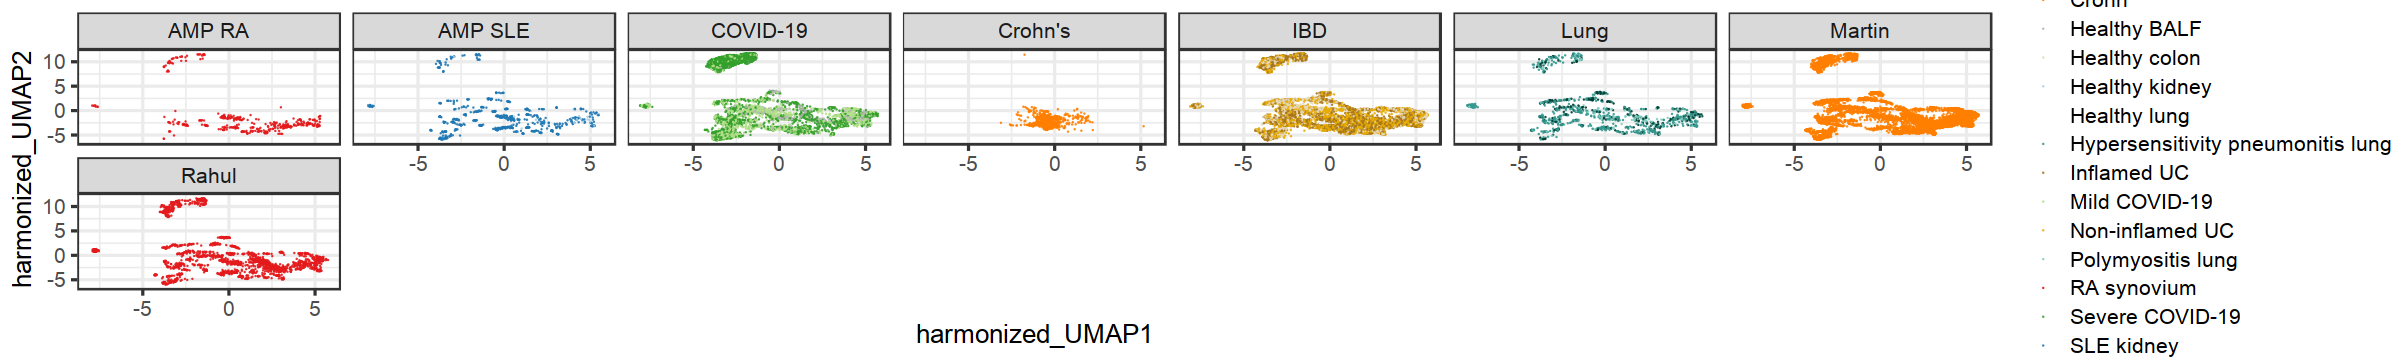

In [175]:
# UMAP with top 20 PCs
library(umap)
umap_res <- umap(harmony_weighted, n_neighbors = 30, metric = "cosine", min_dist = .1)
meta_all_cd8$harmonized_UMAP1 <- umap_res$layout[, 1]
meta_all_cd8$harmonized_UMAP2 <- umap_res$layout[, 2]

options(repr.plot.height = 3, repr.plot.width = 20)
ggplot(meta_all_cd8[sample(nrow(meta_all_cd8)),],
       aes(x = harmonized_UMAP1, y = harmonized_UMAP2, fill= disease_new)
      ) +
  geom_point(size = 0.4, stroke = 0.0001, shape = 21, alpha = 0.9) +
  facet_wrap( ~ dataset, ncol = 7) +
  scale_fill_manual(values = meta_colors$disease, name = "") +
  theme_bw(base_size = 15) 

In [229]:
# saveRDS(meta_all_cd8, "meta_all_weighted_cd8_t_cell_2020-08_25.rds")

## Load integrative results for downstream analysis and visualization

In [6]:
meta_all_cd8 <- readRDS("meta_all_weighted_cd8_t_cell_2020-08_26.rds")
exprs_norm_cd8 <- readRDS("exprs_norm_CD8_T_cell_2020-08-25.rds")
all(meta_all_cd8$cell == colnames(exprs_norm_cd8))

[1] TRUE

In [8]:
meta_all_cd8[which(meta_all_cd8$disease == "OA"),]$disease_new <- "OA synovium"

In [9]:
# [1] "s_non CD"
s_non_CD <- c('S123','S129','S135','S159','S180','S186','S189','S192','S195','S208','S68')
# [1] "s_inf CD"
s_inf_CD <- c('S122','S128','S138','S158','S181','S187','S190','S193','S196','S209','S69')

meta_all_cd8[which(meta_all_cd8$sample %in% s_non_CD),]$disease_new <- "Non-inflamed Crohn"
meta_all_cd8[which(meta_all_cd8$sample %in% s_inf_CD),]$disease_new <- "Inflamed Crohn"

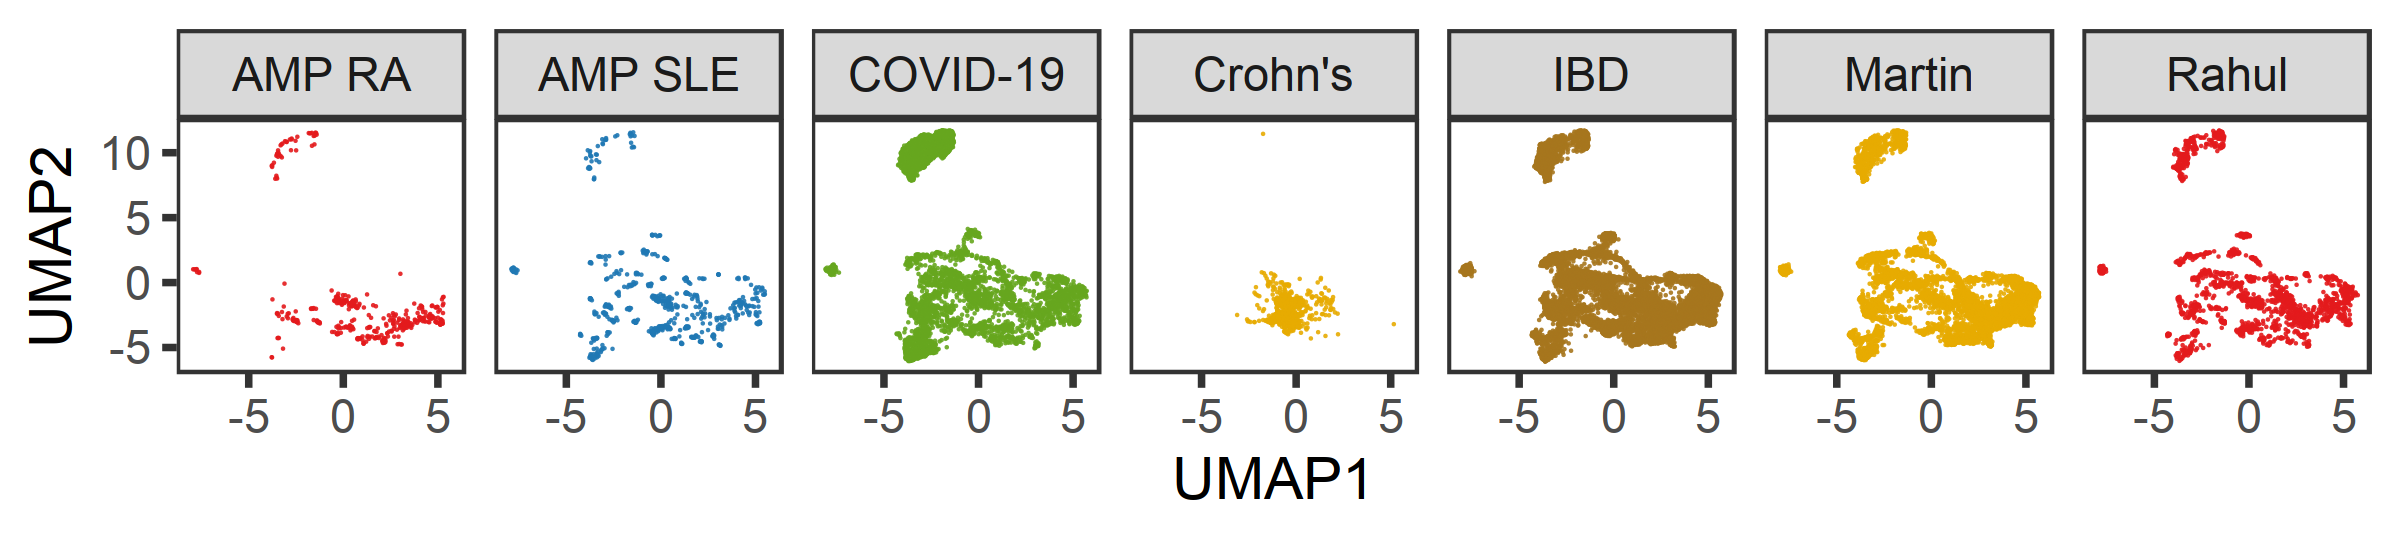

In [31]:
options(repr.plot.height = 4.5, repr.plot.width = 20)
temp <- meta_all_cd8[-which(meta_all_cd8$tissue == "Lung"),]
ggplot(temp[sample(nrow(temp)),],
       aes(x = harmonized_UMAP1, y = harmonized_UMAP2, fill= tissue)
      ) +
  geom_point(size = 1., stroke = 0.0001, shape = 21, alpha = 0.9) +
  facet_wrap( ~ dataset, ncol = 7) +
  scale_fill_manual(values = meta_colors$tissue, name = "") +
  labs(
      x = "UMAP1",
      y = "UMAP2"
      ) +
  theme_bw(base_size = 35) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=15, face = "italic")
)
ggsave(file = paste("by_tissue", ".png", sep = ""), width = 20, height = 4.5, dpi = 300)

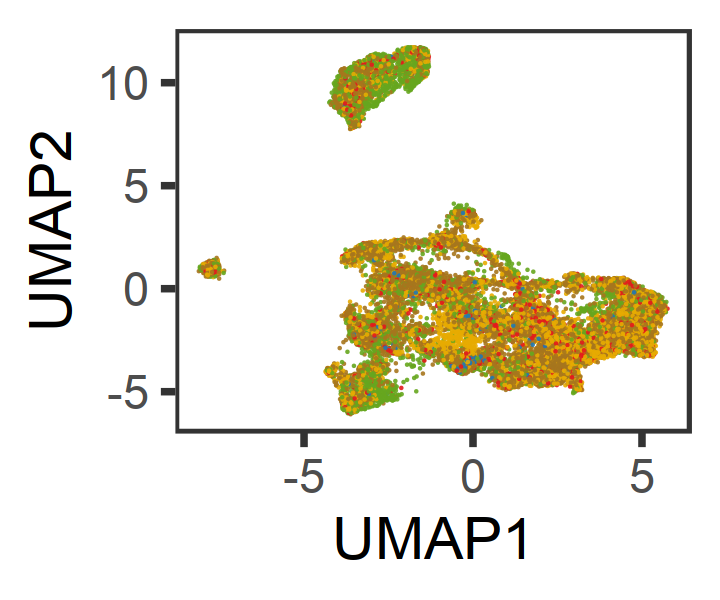

In [18]:
options(repr.plot.height = 5, repr.plot.width = 6)
temp <- meta_all_cd8[-which(meta_all_cd8$tissue == "Lung"),]
ggplot(temp[sample(nrow(temp)),],
       aes(x = harmonized_UMAP1, y = harmonized_UMAP2, fill= tissue)
      ) +
  geom_point(size = 1., stroke = 0.0001, shape = 21, alpha = 0.9) +
  scale_fill_manual(values = meta_colors$tissue, name = "") +
  labs(
      x = "UMAP1",
      y = "UMAP2"
      ) +
  theme_bw(base_size = 35) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=15, face = "italic")
)

In [231]:
# BuildSNNSeurat
library(parallel)
snn_pcs <- BuildSNNSeurat(meta_all_cd8[, c(13:32)], nn.eps = .5)
dim(snn_pcs)

[1] 29363 29363

In [232]:
# for weighted clustering, weigh the SNN before passing it to Louvain: 
snn_pcs <- snn_pcs %*% Matrix::Diagonal(x = weights) 
dim(snn_pcs)

[1] 29363 29363

In [248]:
# Louvain
resolution_list <- c(0.1, 0.2, 0.4)
ids_cos <- Reduce(cbind, mclapply(resolution_list, function(res_use) {
    Seurat:::RunModularityClustering(SNN = snn_pcs, modularity = 1, 
        resolution = res_use, algorithm = 3, n.start = 10, 
        n.iter = 10, random.seed = 0, print.output = FALSE, 
        temp.file.location = NULL, edge.file.name = NULL)    
}, mc.cores = min(16, length(resolution_list))))
ids_cos %<>% data.frame()
colnames(ids_cos) <- sprintf("res_%.2f", resolution_list)
meta_all_cd8$res_0.10 <- ids_cos$res_0.10
meta_all_cd8$res_0.20 <- ids_cos$res_0.20
meta_all_cd8$res_0.40 <- ids_cos$res_0.40

In [250]:
# saveRDS(meta_all_cd8, "meta_all_weighted_cd8_t_cell_2020-08_26.rds")

Warning message:
“`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


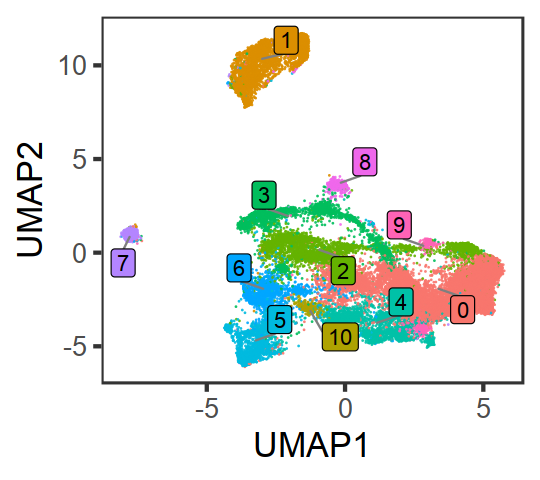

In [43]:
meta_all_cd8$res_0.10 <- as.character(meta_all_cd8$res_0.10)
cluster_center <- meta_all_cd8 %>%
                  group_by(res_0.10) %>%
                  summarise_at(vars(harmonized_UMAP1, harmonized_UMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)
cluster_center$res_0.10 <- as.character(cluster_center$res_0.10)

options(repr.plot.height = 4, repr.plot.width = 4.5)
ggplot(meta_all_cd8,
       aes(x = harmonized_UMAP1, y = harmonized_UMAP2, fill= res_0.10)
      ) +
  geom_point(size = 0.5, stroke = 0.0001, shape = 21, alpha = 0.9) +
  geom_label_repel(
    data = cluster_center,
    aes(label = res_0.10, fill = res_0.10),
#     fontface = 'bold', 
    size = 4.5, 
    box.padding = unit(0.4, "lines"),
    point.padding = unit(0.2, "lines"),
    segment.color = 'grey50'
  ) +
#   scale_fill_manual(values = meta_colors$cluster, name = "") +
  labs(
      x = "UMAP1",
      y = "UMAP2"
      ) +
  theme_bw(base_size = 20) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=15, face = "italic")
)

## Load Gzmk and Gzmb genes

In [3]:
final_gzmb <- readRDS("../2019_03_01_CD8_Brenner_data/2019_03_01_CD8_Brenner_data/final_gzmb.rds")
final_gzmk <- readRDS("../2019_03_01_CD8_Brenner_data/2019_03_01_CD8_Brenner_data/final_gzmk.rds")

print("final_gzmb")
final_gzmb
print("final_gzmk")
final_gzmk

[1] "final_gzmb"


[1] "CCND3"    "CD300A"   "CLIC3"    "FCER1G"   "FCGR3A"   "FCRL6"   
 [7] "FGFBP2"   "FGR"      "GNLY"     "GZMB"     "HMGN3"    "HOPX"    
[13] "IFITM1"   "KLRD1"    "KLRF1"    "MATK"     "MYO1F"    "MYO1G"   
[19] "MYOM2"    "PLAC8"    "PLEK"     "PRSS23"   "SLC9A3R1" "SPON2"   
[25] "TBC1D10C" "TPST2"    "TTC38"    "TYROBP"   "UCP2"     "XIST"    
[31] "ZAP70"    "ZEB2"

[1] "final_gzmk"


[1] "ARRDC3"   "BTG2"     "CD69"     "CNN2"     "COTL1"    "CRTAM"   
 [7] "DDIT4"    "DNAJB1"   "FABP5"    "GPR171"   "HSPA1A"   "IFRD1"   
[13] "LTB"      "LYAR"     "MIAT"     "NAP1L1"   "NR4A2"    "ODF2L"   
[19] "RGCC"     "RGS1"     "RGS2"     "SH2D1A"   "SOCS3"    "TAGAP"   
[25] "TIGIT"    "ZNF331"   "CD27"     "CD44"     "CREM"     "CXCR4"   
[31] "DUSP2"    "DUSP4"    "EML4"     "GZMK"     "LEPROTL1" "PIK3R1"  
[37] "PLP2"     "SPOCK2"   "TNFAIP3"  "APOBEC3G"

# Sum of the percent of Gzmk signature expressing cells

In [7]:
temp <- as.matrix(exprs_norm_cd8[which(rownames(exprs_norm_cd8) %in% final_gzmk),])
temp <- cbind(meta_all_cd8[, c("sample")], as.data.frame(t(temp)))

gzmk_percent <- temp %>%
    dplyr::group_by(sample) %>%
    dplyr::summarize_at(vars(ARRDC3:TNFAIP3), function(x) sum(x > 0)/n() * 100)  
                        
# Sum all signatures
gzmk_percent$percent <- rowMeans2(as.matrix(gzmk_percent[,c(2:ncol(gzmk_percent))]))
                        
test <- melt(table(meta_all_cd8$disease_new, meta_all_cd8$sample))
test <- test[-which(test$value == 0),]
test <- test[, -3]
colnames(test) <- c("disease_new", "sample")
                        
gzmk_percent_new <- merge(gzmk_percent, test, by = "sample")
gzmk_percent_new$disease_new <- as.character(gzmk_percent_new$disease_new)


In [8]:
temp <- as.matrix(exprs_norm_cd8[which(rownames(exprs_norm_cd8) %in% final_gzmb),])
dim(temp)
temp <- cbind(meta_all_cd8[, c("sample")], as.data.frame(t(temp)))

gzmb_percent <- temp %>%
    dplyr::group_by(sample) %>%
    dplyr::summarize_at(vars(CCND3:ZEB2), function(x) sum(x > 0)/n() * 100)
                       
# Sum all genes
gzmb_percent$percent <- rowMeans(as.matrix(gzmb_percent[,c(2:ncol(gzmb_percent))]))
                        
test <- melt(table(meta_all_cd8$disease_new, meta_all_cd8$sample))
test <- test[-which(test$value == 0),]
test <- test[, -3]
colnames(test) <- c("disease_new", "sample")
                        
gzmb_percent_new <- merge(gzmb_percent, test, by = "sample")
gzmb_percent_new$disease_new <- as.character(gzmb_percent_new$disease_new)

In [15]:
temp1 <- gzmk_percent_new[, c("sample", "percent", "disease_new")]
temp2 <- gzmb_percent_new[, c("sample", "percent", "disease_new")]

gzmk_gzmb_percent <- rbind(temp1, temp2)
gzmk_gzmb_percent$percent_type <- c(rep("GzmK percent", nrow(temp1)), rep("GzmB percent", nrow(temp2)))
colnames(gzmk_gzmb_percent)[3] <- "d"
gzmk_gzmb_percent[1:4,]

# saveRDS(gzmb_gzmb_percent, "gzmb_gzmb_percent_2.rds")

,sample,percent,d,percent_type
,<chr>,<dbl>,<chr>,<chr>
1,200-0061,30.26316,SLE kidney,GzmK percent
2,200-0105,36.84211,SLE kidney,GzmK percent
3,200-0108,48.08612,SLE kidney,GzmK percent
4,200-0109,41.49123,SLE kidney,GzmK percent


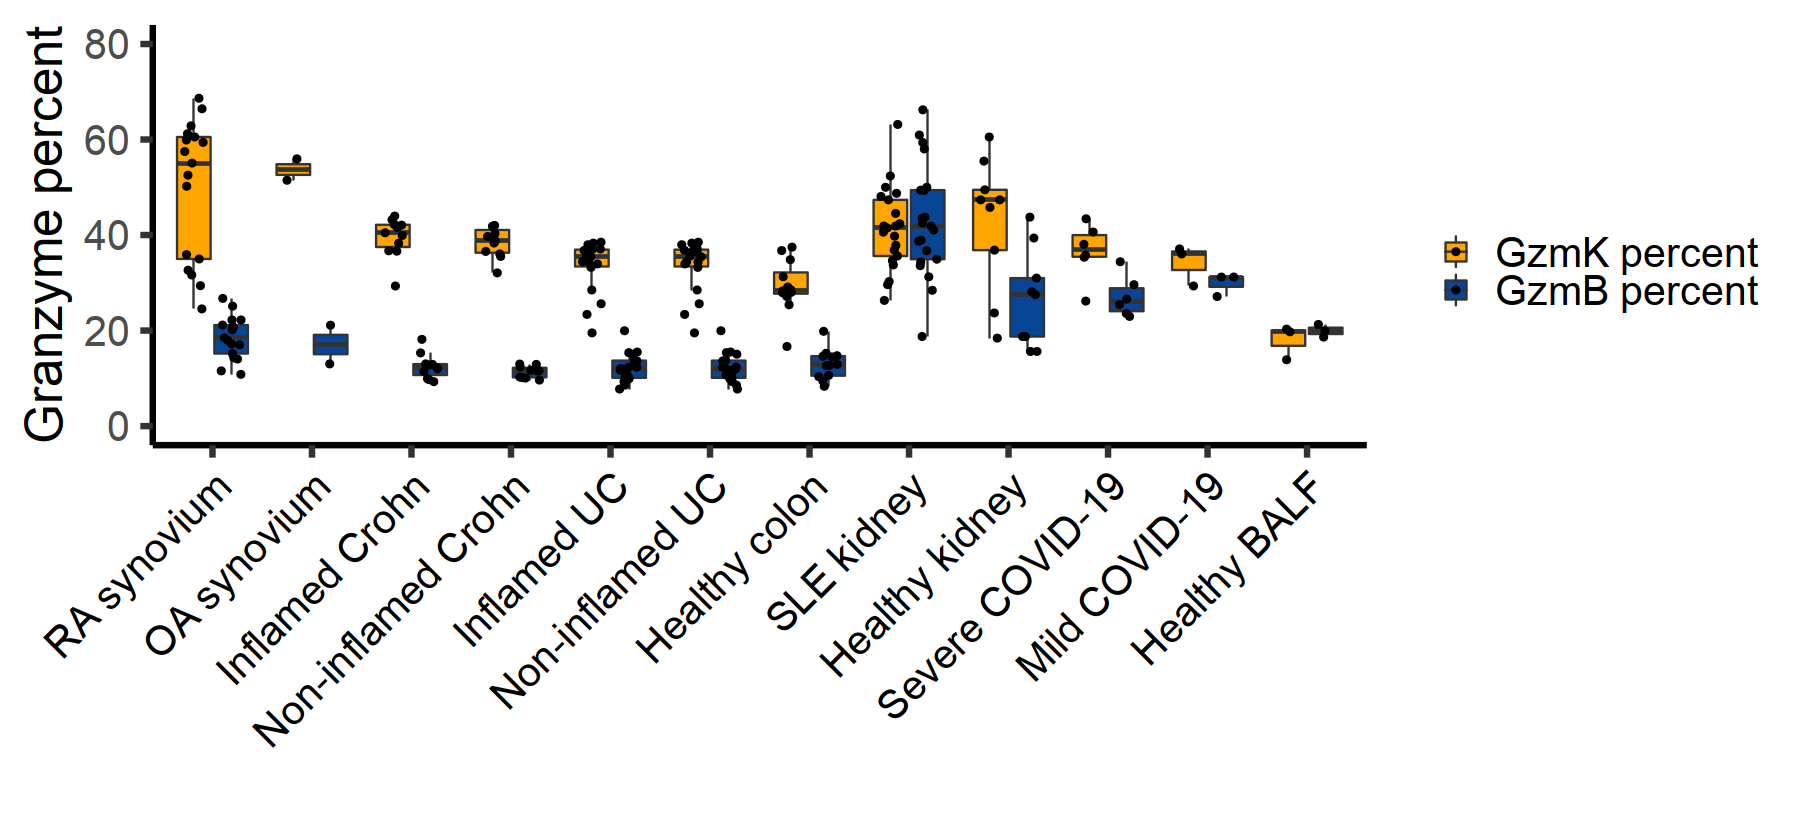

In [111]:
# RA, OA, Crohn, UC, SLE, COVID
# Seperate by tissue
# Autoimmune disease and viral disease
gzmk_gzmb_percent$d <- factor(gzmk_gzmb_percent$d, 
                              levels = c("RA synovium", "OA synovium", "Inflamed Crohn", "Non-inflamed Crohn", "Inflamed UC", "Non-inflamed UC", "Healthy colon", 
                                         "SLE kidney",   "Healthy kidney", "Severe COVID-19", "Mild COVID-19","Healthy BALF")
                             )  
gzmk_gzmb_percent$percent_type <- factor(gzmk_gzmb_percent$percent_type, levels = c("GzmK percent", "GzmB percent"))


options(repr.plot.height = 7, repr.plot.width = 15)
ggplot(gzmk_gzmb_percent, 
       aes(x= d, y = percent, fill = percent_type)) +
       geom_boxplot(outlier.shape = NA) +
       geom_point(position=position_jitterdodge(), size = 1.5) +
       ylim(0, 80) +
       scale_fill_manual(values = c("orange", "#084594"), name = "") +
       labs(x="", y="Granzyme percent") +
       theme_classic(base_size = 30) +
       theme(
             axis.text.x = element_text(color = "black", hjust = 1, angle = 45)
            ) 
ggsave(file = paste("barplot_percent", ".pdf", sep = ""), width = 15, height = 7, dpi = 300)

In [13]:
library(ggpubr)
stat_percent <- compare_means(percent ~ percent_type, data = gzmk_gzmb_percent, group.by = "d")

write.csv(gzmk_gzmb_percent, "gzmk_gzmb_percent_number.csv", row.names = FALSE)
write.csv(stat_percent, "gzmk_gzmb_percent_stat.csv", row.names = FALSE)

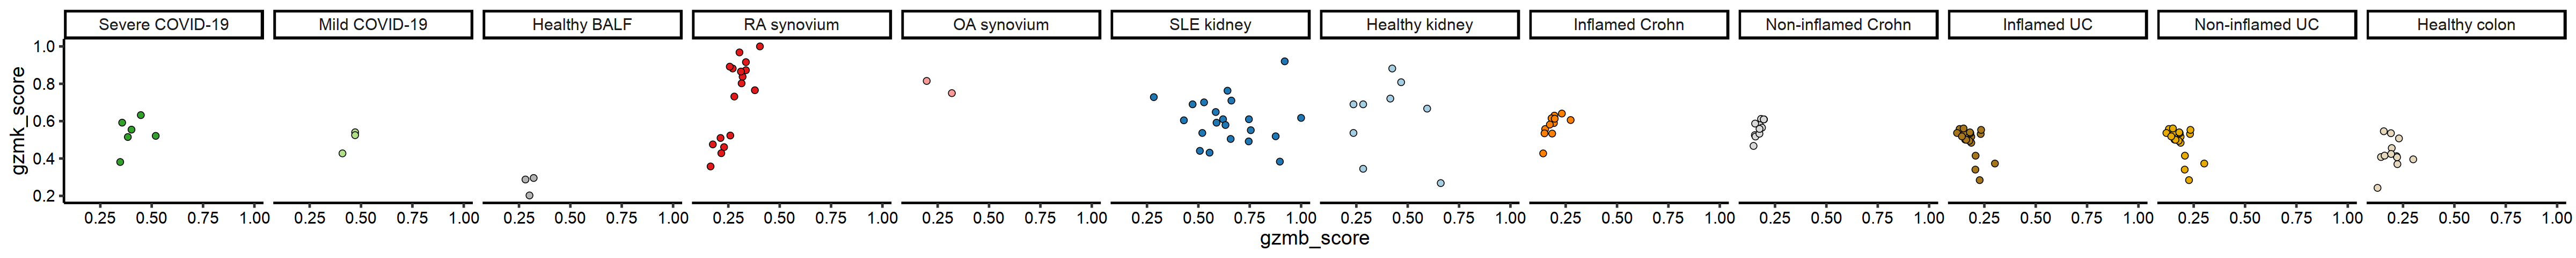

In [264]:
# Ratio of gzmk and gzmb
options(repr.plot.height = 4, repr.plot.width = 40)
ggplot(gzmb_gzmb_percent, aes(x= gzmb_score, y = gzmk_score, fill = disease_new)) +
       geom_point(shape = 21, size = 3) +
       facet_grid( ~ disease_new) +
       scale_fill_manual(values = meta_colors$disease, name = "") +
       theme_classic(base_size = 22) +
       theme(legend.position = "none",
             axis.text = element_text(color = "black")
            ) 

In [35]:
temp1 <- gzmk_percent_new[, c("sample", "gzmk_score", "disease_new")]
temp2 <- gzmb_percent_new[, c("sample", "gzmb_score", "disease_new")]
colnames(temp1)[2] <- "score"
colnames(temp2)[2] <- "score"

gzmb_gzmb_percent <- rbind(temp1, temp2)
gzmb_gzmb_percent$score_type <- c(rep("GzmK score", nrow(temp1)), rep("GzmB score", nrow(temp2)))
colnames(gzmb_gzmb_percent)[3] <- "d"
gzmb_gzmb_percent[1:4,]
# saveRDS(gzmb_gzmb_percent, "gzmb_gzmb_percent_2.rds")

,sample,score,d,score_type
,<chr>,<dbl>,<fct>,<chr>
1,200-0061,0.4408946,SLE kidney,GzmK score
2,200-0105,0.5367412,SLE kidney,GzmK score
3,200-0108,0.7005518,SLE kidney,GzmK score
4,200-0109,0.6044728,SLE kidney,GzmK score


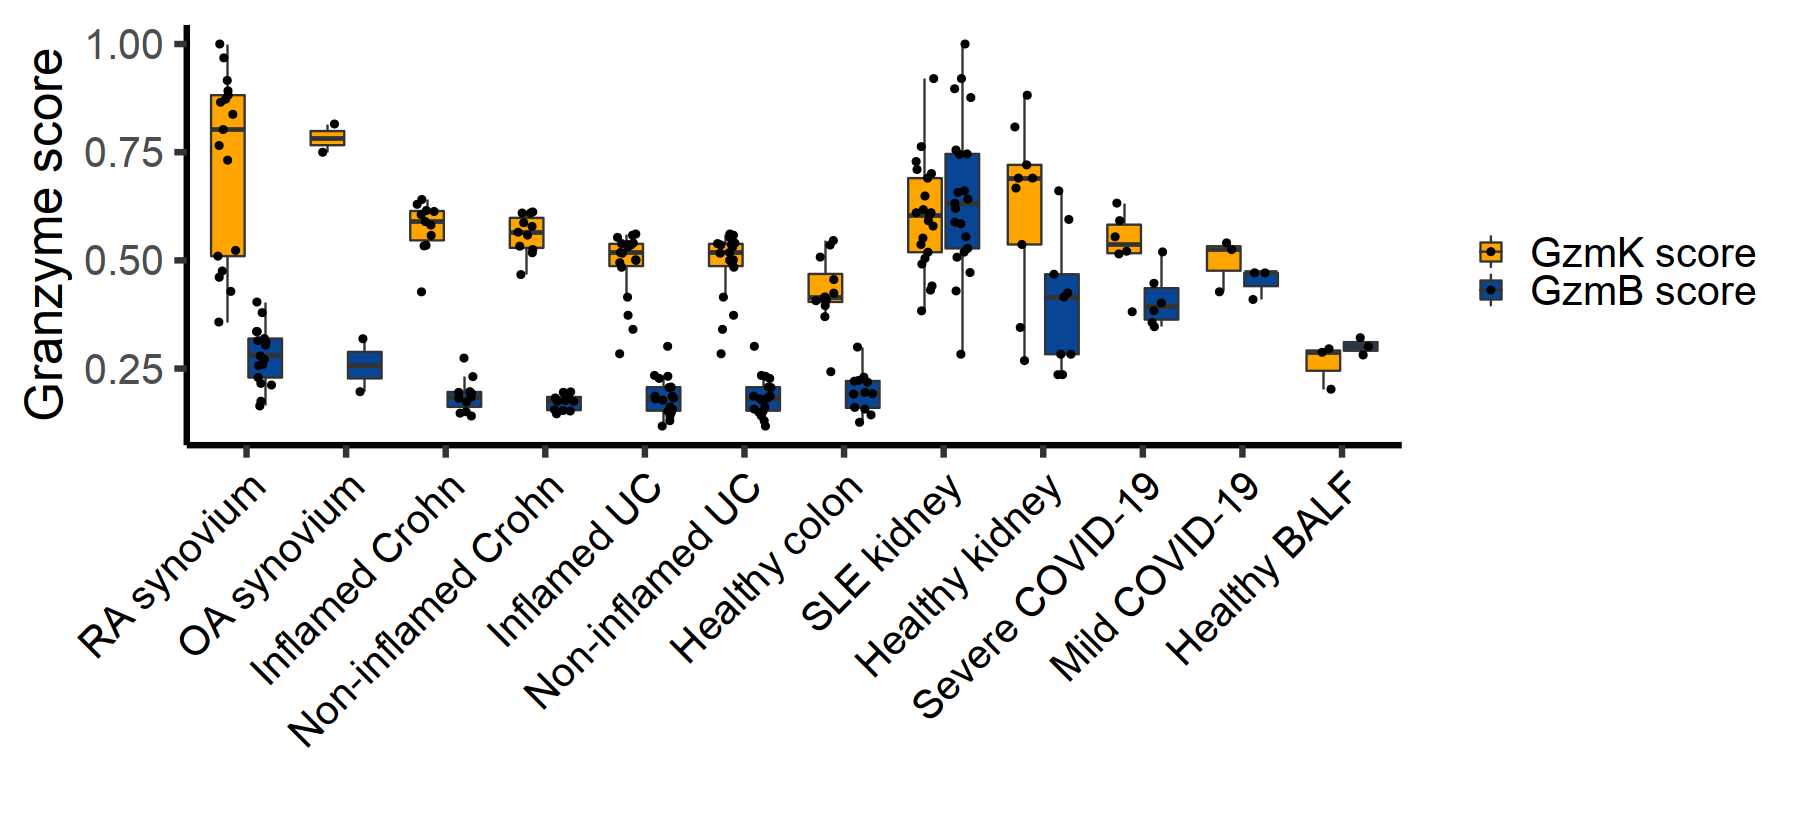

In [37]:
# RA, OA, Crohn, UC, SLE, COVID
# Seperate by tissue
# Autoimmune disease and viral disease
gzmb_gzmb_percent$d <- factor(gzmb_gzmb_percent$d, levels = c("RA synovium", "OA synovium", "Inflamed Crohn",   "Non-inflamed Crohn", "Inflamed UC", "Non-inflamed UC",   
                                                              "Healthy colon", "SLE kidney",   "Healthy kidney", "Severe COVID-19", "Mild COVID-19","Healthy BALF")
                             )  
gzmb_gzmb_percent$score_type <- factor(gzmb_gzmb_percent$score_type, levels = c("GzmK score", "GzmB score"))

options(repr.plot.height = 7, repr.plot.width = 15)
ggplot(gzmb_gzmb_percent, 
       aes(x= d, y = score, fill = score_type)) +
       geom_boxplot(outlier.shape = NA) +
       geom_point(position=position_jitterdodge(), size = 1.5) +
       scale_fill_manual(values = c("orange", "#084594"), name = "") +
       labs(x="", y="Granzyme score") +
       theme_classic(base_size = 30) +
       theme(axis.text.x = element_text(color = "black", hjust = 1, angle = 45)) 

In [11]:
library(ggpubr)
# method = "wilcox.test"
stat_score <- compare_means(score ~ score_type, data = gzmb_gzmb_percent, group.by = "d")

write.csv(gzmb_gzmb_percent, "gzmk_gzmb_score_number.csv", row.names = FALSE)
write.csv(stat_score, "gzmk_gzmb_score_stat.csv", row.names = FALSE)

## Visualization of key marker genes in integrative embeddings

In [10]:
meta_all_cd8_subset <- meta_all_cd8[which(meta_all_cd8$disease_new %in% c( "Healthy colon", "Non-inflamed UC", "Inflamed UC",
                                                                          "Non-inflamed Crohn", "Inflamed Crohn",
                                                                          "OA synovium", "RA synovium", 
                                                                          "Healthy kidney", "SLE kidney",
                                                                          "Healthy BALF", "Mild COVID-19", "Severe COVID-19"
                                                                         )
                                         ),]
meta_all_cd8_subset$disease_new <- factor(meta_all_cd8_subset$disease_new, 
                                                              levels = c( "Healthy colon", "Non-inflamed UC", "Inflamed UC",
                                                                          "Non-inflamed Crohn", "Inflamed Crohn",
                                                                          "OA synovium", "RA synovium", 
                                                                          "Healthy kidney", "SLE kidney",
                                                                          "Healthy BALF", "Mild COVID-19", "Severe COVID-19"
                                                                        )
                                         )

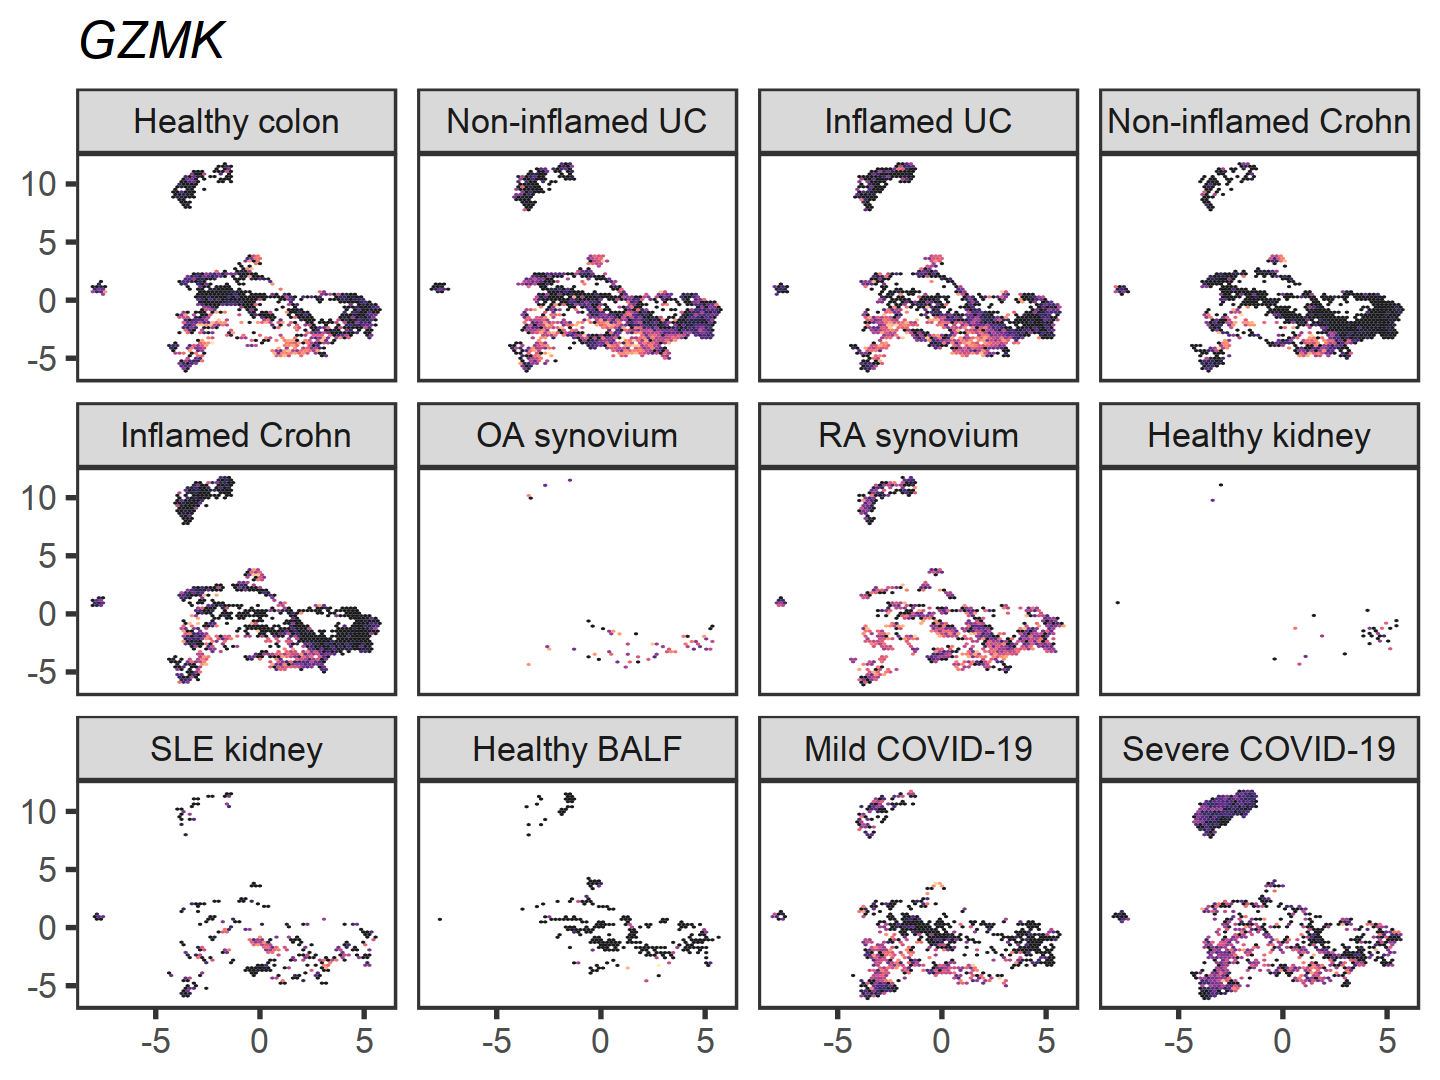

In [199]:
options(repr.plot.height = 9, repr.plot.width = 12)
ggplot(meta_all_cd8_subset,
      ) +
    stat_summary_hex(aes(x = harmonized_UMAP1, y = harmonized_UMAP2, z = gzmk),
                     fun = mean,
                     bins = 70, alpha = 0.9,
                     data = meta_all_cd8_subset
                    ) +
    facet_wrap( ~ disease_new) +
  scale_fill_viridis(option = "magma") +
    guides(
      # fill = guide_colorbar(barwidth = 1, barheight = 10),
      fill = FALSE,
      color = FALSE,
      alpha = "none"
    ) +
    labs(
      x = NULL,
      y = NULL,
      title = "GZMK"
    ) +
    theme_bw(base_size = 25) +
    theme(
      plot.title = element_text(color="black", size=30, face="italic"),
      panel.grid = element_blank()
    ) 
ggsave(file = paste("gzmk", ".pdf", sep = ""), width = 12, height = 9, dpi = 300)

# Generate a table for the integration analysis

In [25]:
sc_table <- meta_all_cd8_subset %>% 
  group_by(disease_new, dataset) %>%
  summarise(number = n())

sc_table$dataset[which(sc_table$dataset == "IBD")] <- "Smillie, et al, 2019"
sc_table$dataset[which(sc_table$dataset == "Martin")] <- "Martin, et al, 2019"
sc_table$dataset[which(sc_table$dataset == "AMP RA")] <- "Zhang, et al, 2019"
sc_table$dataset[which(sc_table$dataset == "Rahul")] <- "Stephenson, et al, 2018"
sc_table$dataset[which(sc_table$dataset == "AMP SLE")] <- "Arazi, et al, 2019"
sc_table$dataset[which(sc_table$dataset == "COVID-19")] <- "Liao, et al, 2020"

`summarise()` regrouping output by 'disease_new' (override with `.groups` argument)



In [41]:
dim(sc_table)
sc_table

[1] 13  4

disease_new,dataset,number,sample
<fct>,<chr>,<int>,<dbl>
Healthy colon,"Smillie, et al, 2019",3466,12
Non-inflamed UC,"Smillie, et al, 2019",4623,18
Inflamed UC,"Smillie, et al, 2019",3865,18
Non-inflamed Crohn,"Martin, et al, 2019",3791,11
Inflamed Crohn,"Martin, et al, 2019",3227,11
OA synovium,"Zhang, et al, 2019",67,2
RA synovium,"Zhang, et al, 2019",340,12
RA synovium,"Stephenson, et al, 2018",1777,5
Healthy kidney,"Arazi, et al, 2019",32,9


In [42]:
write.table(sc_table, file = paste("table_CD8_T_cell_sc_datasets", ".txt", sep = ""),
             row.names=T,col.names=T, quote = F, sep = "\t")